# Wasserstein statistical manifold上のWasserstein勾配流

## グラフ作成

In [1]:
import numpy as np
import networkx as nx
nodes = ["1","2","3","4"]
#辺は辞書式順序
edges = [("1","2"),("1","3"),("2","4"),("3","4")]
Gw=nx.Graph()
Gw.add_nodes_from(nodes)
Gw.add_edges_from(edges)

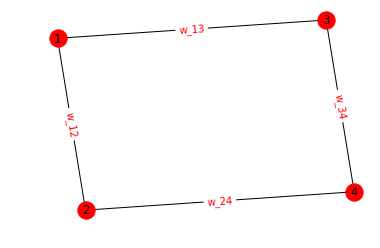

In [3]:
#描画
import matplotlib.pyplot as plt
pos = nx.spring_layout(Gw)
nx.draw_networkx(Gw, pos, with_labels=True)
nx.draw_networkx_edge_labels(Gw,pos,edge_labels={('1','2'):'w_12',\
('1','3'):'w_13',('2','4'):'w_24',('3','4'):'w_34'},font_color='red')
plt.axis("off")
plt.show()

# SympyによるWSM metric tensorの計算

In [4]:
#SympyのインポートとTex形式での出力設定
import sympy as sp
from IPython.display import display
from IPython.display import Math
sp.init_printing()
#文字式宣言
probs_name=[]
for node in nodes:
    probs_name.append(sp.Symbol("p_"+node))
weights_name=[]
for edge in edges:
    weights_name.append(sp.Symbol("w_"+edge[0]+edge[1]))

### Discrete gradient operatorの作成

In [6]:
D=[[0]*len(nodes) for i in range(len(edges))]
for i,edge in enumerate(edges):
    for j,node in enumerate(nodes):
            if(node==edge[0]):
                D[i][j]=sp.sqrt(weights_name[i])
            elif(node==edge[1]):
                D[i][j]=-sp.sqrt(weights_name[i])
D=sp.Matrix(D)
display(Math(r'D = %s' % (sp.latex(D))))

<IPython.core.display.Math object>

### Weight matrixの作成

In [7]:
Lamb=[]
for edge in edges:
    Lamb.append((probs_name[int(edge[0])-1]+probs_name[int(edge[1])-1])/2)
Lamb=sp.diag(*Lamb)
display(Math(r'\Lambda(p) = %s' % (sp.latex(Lamb))))

<IPython.core.display.Math object>

## グラフラプラシアン（Weighted laplacian matrix） の作成

In [9]:
L=(D.T)*Lamb*D
display(Math(r'D^{T}\Lambda(p)D = %s' % (sp.latex(L))))

<IPython.core.display.Math object>

# パラメータ空間でのWasserstein勾配流の計算

$G$上のパラメトリックな確率分布として
$$
p(a)(i)=\begin{cases}
(1-a_1)(1-a_2)\quad &i=1\\
(1-a_1)a_2\ &i=2\\
a_1(1-a_2) &i=3\\
a_1a_2&i=4\\
\end{cases}
,\quad0\leq a_1,a_2\leq1
$$
とする。ヤコビ行列は

In [10]:
a_1,a_2=sp.symbols("a_1 a_2")
J=[[]*2 for i in range(len(nodes))]
J[0]=[-(1-a_2),-(1-a_1)]
J[1]=[-a_2,-(1-a_1)]
J[2]=[1-a_2,-a_1]
J[3]=[a_2,a_1]
J=sp.Matrix(J)
display(Math(r'J_ap(a) = %s' % (sp.latex(J))))

<IPython.core.display.Math object>

となりパラメータ空間$\Theta$の計量は
$$
G(a)=J_ap(a)^{T}L(p(a))^{\dagger}J_ap(a)=J_ap(a)^{\dagger}L(p(a))(J^{T})^\dagger.
$$

In [11]:
#Lの擬逆行列の計算コスト大
#G=J.T*L.pinv()*J
J_pinv=J.pinv()
G_inv=J_pinv*L*J_pinv.T

汎関数$F$を$G$上のポテンシャル関数$f$を$$
f(i)=\begin{cases}
0\quad&i=1\\
-2 &i=2\\
-4 &i=3\\
6  &i=4
\end{cases}
$$として$F(p)=E_p[f]$と定義する.これはパラメータで表すと
$$
F(p(a))=\sum_{i\in I}f(i)p(a)(i)=-4a_1-2a_2+12a_1a_2
$$であり
$$
\nabla_aF(p(a))=(-4+12a_2,-2+12a_1)^T
$$よりWasserstein勾配流は
$$
\dot a=-G(a)^{-1}\nabla_aF(p(a))
$$
の形で書ける.

この汎関数は以下の論文に登場したものである.

L. Malago and G. Pistone. Natural Gradient Flow in the Mixture Geometry of a Discrete Exponential
Family. Entropy, 17(12):4215–4254, 2015.

# 数値計算

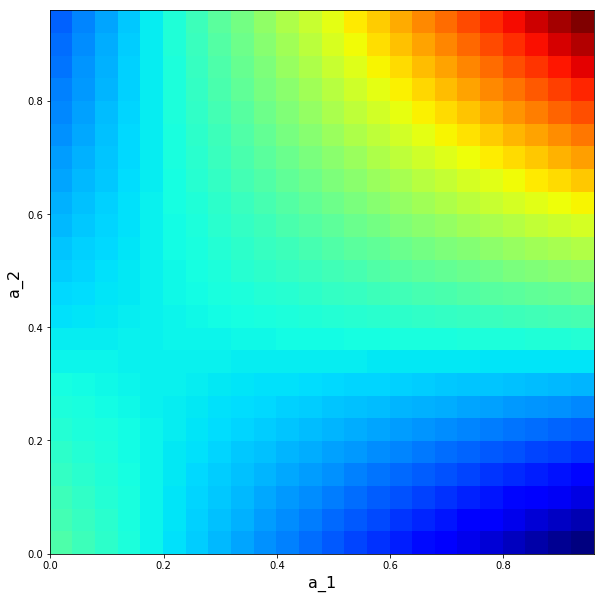

In [168]:
#パラメータメッシュグリッド&描画範囲の生成
from pylab import rcParams
rcParams['figure.figsize'] = 10,10
x = np.arange(0, 1, 0.04)
y = np.arange(0, 1, 0.04)
X, Y = np.meshgrid(x, y)
F=-4*X-2*Y+12*X*Y
plt.pcolormesh(X, Y, F, cmap='jet')
plt.xlabel('a_1', fontsize=16)
plt.ylabel('a_2', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

In [133]:
#文字式の代入
def Set_Nums(symb_names,symb_nums):
    symb_subs=[]
    for name,num in zip(symb_names,symb_nums):
        symb_subs.append((name,num))
    return symb_subs
def WGD(G_weight_num,pn1,pn2):
    parms_sub=[(a_1,pn1),(a_2,pn2)]
    probs_sub=Set_Nums(probs_name,[(1-pn1)*(1-pn2),(1-pn1)*pn2,pn1*(1-pn2),pn1*pn2])
    G_num=G_weight_num.subs(parms_sub+probs_sub)
    G_num=np.array(G_num).astype("float64")
    GRAD_F=np.array([-4+12*pn1,-4+12*pn2]).T
    ans= -np.dot(G_num,GRAD_F)
    return ans[0],ans[1]

## Case1.
$w_{12}=w_{13}=w_{34}=1,w_{24}=1$

In [171]:
G_weight_num=G_inv.subs(Set_Nums(weights_name,[1,1,1,1]))
WGD_num=np.vectorize(lambda x,y: WGD(G_weight_num=G_weight_num,pn1=x,pn2=y))
U,V=WGD_num(X,Y)

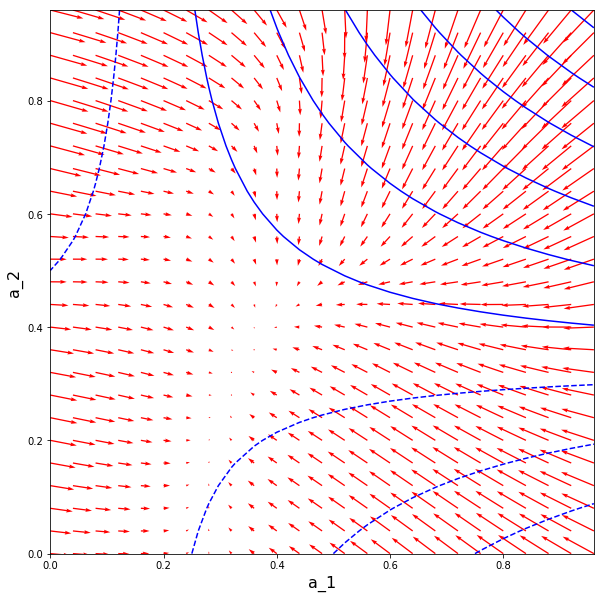

In [177]:
cont=plt.contour(X,Y,F,  10,colors=['blue'])
plt.xlabel('a_1', fontsize=16)
plt.ylabel('a_2', fontsize=16)
plt.axes().set_aspect('equal')
plt.quiver(X,Y,U,V,color='red',angles='xy',scale_units='xy', scale=70)
plt.show()

## Case2.
$w_{12}=w_{13}=w_{34}=1,w_{24}=0.1$

In [178]:
G_weight_num=G_inv.subs(Set_Nums(weights_name,[1,1,1,0.1]))
WGD_num=np.vectorize(lambda x,y: WGD(G_weight_num=G_weight_num,pn1=x,pn2=y))
U,V=WGD_num(X,Y)

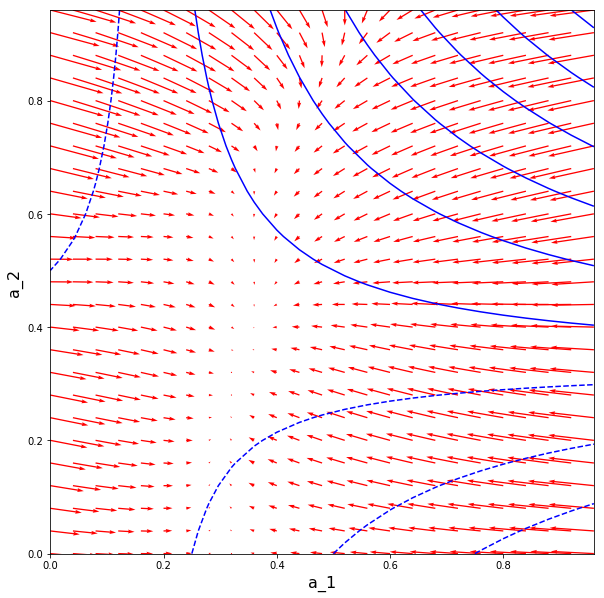

In [181]:
cont=plt.contour(X,Y,F,  10,colors=['blue'])
plt.xlabel('a_1', fontsize=16)
plt.ylabel('a_2', fontsize=16)
plt.axes().set_aspect('equal')
plt.quiver(X,Y,U,V,color='red',angles='xy',scale_units='xy', scale=50)
plt.show()

## Case3.
$w_{12}=w_{13}=w_{34}=1,w_{24}=10$

In [182]:
G_weight_num=G_inv.subs(Set_Nums(weights_name,[1,1,1,10]))
WGD_num=np.vectorize(lambda x,y: WGD(G_weight_num=G_weight_num,pn1=x,pn2=y))
U,V=WGD_num(X,Y)

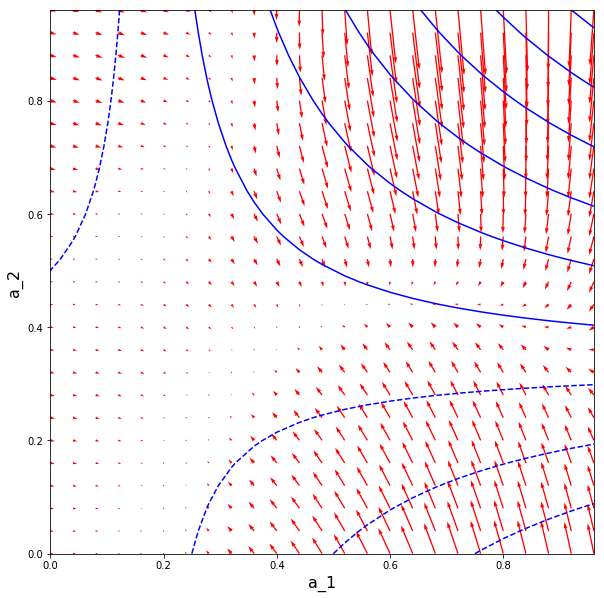

In [186]:
cont=plt.contour(X,Y,F,  10,colors=['blue'])
plt.xlabel('a_1', fontsize=16)
plt.ylabel('a_2', fontsize=16)
plt.axes().set_aspect('equal')
plt.quiver(X,Y,U,V,color='red',angles='xy',scale_units='xy', scale=400)
plt.show()

## Case4.自然勾配法
$$
p(a)(i)=\begin{cases}
(1-a_1)(1-a_2)\quad &i=1\\
(1-a_1)a_2\ &i=2\\
a_1(1-a_2) &i=3\\
a_1a_2&i=4\\
\end{cases}
,\quad0\leq a_1,a_2\leq1
$$
のフィッシャー情報行列は
$$
G_{\mathrm{Fisher}}=\begin{bmatrix}
\frac{1}{a_1(1-a_1)} & 0\\
0&\frac{1}{a_2(1-a_2)}  \\
\end{bmatrix}
$$
より自然勾配法の勾配方向は
$$
-G_{\mathrm{Fisher}}(a)^{-1}\nabla_aF(p(a))
$$
となる

In [187]:
G_Fisher=sp.Matrix([[1/(a_1*(1-a_1)),0],[0,1/(a_2*(1-a_2))]])
G_Fisher_inv=G_Fisher.inv()
WGD_num=np.vectorize(lambda x,y: WGD(G_weight_num=G_Fisher_inv,pn1=x,pn2=y))
U,V=WGD_num(X,Y)

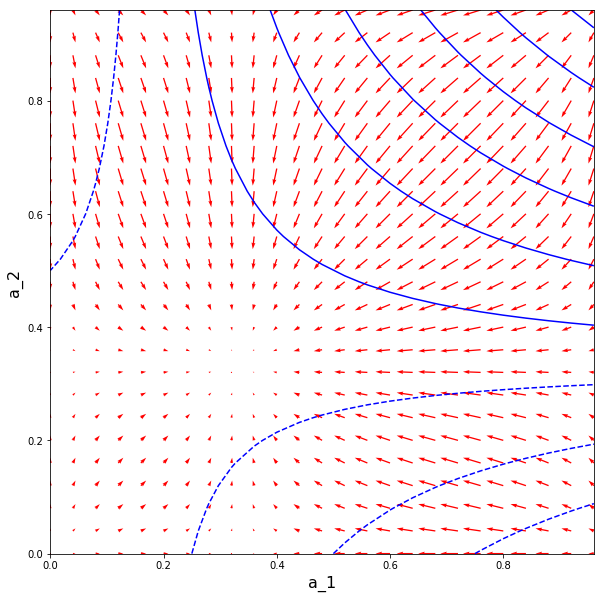

In [188]:
cont=plt.contour(X,Y,F,  10,colors=['blue'])
plt.xlabel('a_1', fontsize=16)
plt.ylabel('a_2', fontsize=16)
plt.axes().set_aspect('equal')
plt.quiver(X,Y,U,V,color='red',angles='xy',scale_units='xy', scale=30)
plt.show()